In [1]:
import sys, os
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
from PyQt5.QtCore import *
import random
import cv2
import numpy as np
import math
from math import log
from View import ImageViewer

#画像取り込み、切り抜き、ステータス生成をする
class MonsterGenerator:
    def __init__(self, parent):
        self.parent = parent
        
    #画像を取得し親に渡す
    def capture(self):
        # ファイル選択ダイアログの表示
        file_name = QFileDialog.getOpenFileName(self.parent, 'Open file', './')     # 画像を選択してファイル名を取得
        if file_name[0] == '':
            return    
       
        n = np.fromfile(file_name[0], dtype=np.uint8)# imreadだと日本語のファイル名に対応できないため，np.fromfileとcv2.imdecodeを使う
        image = cv2.imdecode(n, cv2.IMREAD_COLOR) 
        self.image = image
        #画像をセットする
        self.parent.setImage(image)

    #画像を切り抜く
    def crop(self, image):
        #TODO 切り抜き方法を工夫する
        height, width, dim = image.shape
        return image[height//4 :height*3//4, width//4 :width*3//4,:]


    #ステータスを生成して返す
    def generateStatus(self, image, debug=False):
        #rgb成分の割合の算出
        bgr_hist = image.T.sum(axis=1).sum(axis=1) 
        bgr_hist = bgr_hist / max(sum(bgr_hist), 1)
        
        #グレースケール画像
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 256
        
        #フーリエ変換・パワースペクトル画像の算出
        f = np.fft.fft2(image_gray, axes=(0,1))
        fshift = np.fft.fftshift(f)
        foo = np.abs(fshift)
        foo = np.where(foo < 1, 1, foo)
        magnitude_spectrum = 20 * np.log(foo) 

        h, w = magnitude_spectrum.shape
        
        #振幅の和
        sum_spec = np.sum(magnitude_spectrum) / w / h
        sum_spec = sum_spec if sum_spec > 0 else 1
        
        #中心の1/4部分
        low = np.sum(magnitude_spectrum[h//4:h*3//4, w//4:w*3//4]) / w / h
        #それ以外　外周の部分
        high = sum_spec - low
        
        #それぞれの面積を考慮した値
        high_std = high * 4 / 3 / sum_spec # 面積の3/4を占めるので 4/3倍
        low_std = low * 4 / sum_spec # 面積の1/4を占めるので 4倍
        
        #単純な全体に占める割合
        high_ratio = high / sum_spec
        low_ratio = low / sum_spec
        
        #体力に関する定数値
        hp_base1 = 100
        hp_base2 = 1
        hp_freq = (log(sum_spec) -hp_base2)
        hp_color = (bgr_hist[1]/0.33)**2
        
        #攻撃力に関する定数値
        attack_base = 100
        attack_freq = high_ratio/0.5
        attack_color = (bgr_hist[2]/0.33)**2
        
        #防御力に関する定数値
        defence_base = 100
        defence_freq = low_ratio/0.5
        defence_color = (bgr_hist[0]/0.33)**2
            
        status = Status()
        status.hp = max(1, round(hp_base1 * hp_freq * hp_color))
        status.attack = max(1, round(attack_base * attack_freq * attack_color))
        status.defence = max(1, round(defence_base * defence_freq * defence_color))
        
        if debug:
            #テスト用の出力
            print("bgr: " , bgr_hist)
            # print("sum:", sum_spec, log(sum_spec))
            # print("high:", high, high_ratio, high_std)
            # print("low:", low, low_ratio, low_std)
            
            print("base * freq * color = value")
            print("hp(green) info : %f * %f * %f = %d" % (hp_base1, hp_freq, hp_color, status.hp))
            print("atk(red) info: %f * %f * %f = %d" % (attack_base, attack_freq, attack_color, status.attack))
            print("def(blue) info: %f * %f * %f = %d" % (defence_base, defence_freq, defence_color, status.defence))

            print("status:", status.hp, status.attack, status.defence)
            print("")
            
        return status
        
    def grabcut(self, image):
        pass

    def convertImage(self, image, mask=None):
        if mask is None:
            return image
        
        

        bgr_average = image[mask == 1].T
    def generateMonster(self, image):
        monster = Monster(self.crop(image))
        #monster.status = self.generateStatus(image)
        monster.status = self.generateStatus(image, True)
        return monster



class Status:
    def __init__(self, hp=0, attack=0, defence=0):
        self.hp = hp
        self.attack = attack
        self.defence = defence
    
    def print(self):
        print("status:", self.hp, self.attack, self.defence)

class Battle:
    #プレイヤーとエネミーを初期化でもらってくる
    def __init__(self, player=None, enemy=None):
        #プレイヤーは初期化時に渡される
        self.player = player
        
        #ステータスを決め打ちで決める
        #self.player = Monster(None)
        #self.player.status = Status(20,5,25)

        self.enemy = enemy
        #敵も決め打ち
        #self.enemy = Monster(None)
        #self.enemy.status=Status(20,5,0)
        
        #1ターン行動するボタン
        self.button_act = None

    def act_one_turn(self):
        #プレイヤーが敵に攻撃する
        self.enemy.take_damage(self.damage_calculater(self.player.status.attack,self.enemy.status.defence))
        print("tekinohp",max(self.enemy.status.hp,0))
        self.end_check(self.enemy.status.hp,0)
        #敵がプレイヤーに攻撃する
        self.player.take_damage(self.damage_calculater(self.enemy.status.attack,self.player.status.defence))
        print("mikatanohp",max(self.player.status.hp,0))
        self.end_check(self.player.status.hp,1)
            
    def damage_calculater(self,attack,defence,power=1):
        base=max(attack-defence,1)
        rando=random.uniform(0.85,1.15)
        damage=math.ceil(base*power*rando)
        return damage
        
    def end_check(self,hp,side):
        if hp<=0:
            print("戦闘終了")
            #TODO その他、戦闘終了処理

    
    

class Monster:
    def __init__(self, image, status=Status()):
        self.status = status
        self.image = image

    def take_damage(self, attack):
        self.status.hp = max(0,self.status.hp-attack)       



class MyWindow(QMainWindow):
    def __init__(self):
        super(MyWindow, self).__init__()
        self.generator = MonsterGenerator(self)

        self.width = 800
        self.height = 600

        self.initUI()
        self.show()

    def initUI(self):
        self.resize(self.width, self.height)
        self.setWindowTitle('Game')
        #ボタン生成・クリック時の挙動、座標設定
        captureButton = QPushButton('モンスター生成', self)
        captureButton.clicked.connect(self.generator.capture)
        captureButton.move(80,20)

        self.actButton = QPushButton('たたかう', self)
        self.actButton.clicked.connect(self.testAct)
        self.actButton.move(550, 400)
        self.actButton.setEnabled(False)

        #文字生成？
        label = QLabel("test", self)
        label.move(200, 20)

        #ステータス表示
        self.statusLabels = []
        self.statusLabels.append(QLabel("hp: undefined", self))
        self.statusLabels.append(QLabel("attack: undefined", self))
        self.statusLabels.append(QLabel("defence: undefined", self))
        for i in range(0, 3):
            self.statusLabels[i].move(450 , 320 + i*20)

        #テスト用の敵表示
        self.enemyStatusLabels = []
        self.enemyStatusLabels.append(QLabel("hp: undefined", self))
        self.enemyStatusLabels.append(QLabel("attack: undefined", self))
        self.enemyStatusLabels.append(QLabel("defence: undefined", self))
        for i in range(0, 3):
            self.enemyStatusLabels[i].move(600 , 320 + i*20)


        #画像生成　self.show()の前に作っておかないと表示されない＜ーなんで？
        self.imageViewer = ImageViewer(self, x=50, y=100)
        #画像が表示される大きさを指定
        self.imageViewer.resize(300, 300)

        self.iconViewer = ImageViewer(self, x=450, y=100)
        #画像が表示される大きさを指定
        self.iconViewer.resize(200, 200)


    def setImage(self, image):
        #画像を選択後に呼び出される
        #元画像と切り抜き後の画像をセットする
        self.image = image
        self.player = self.generator.generateMonster(self.image)

        self.imageViewer.setImage(image)
        self.iconViewer.setImage(self.player.image)

        self.statusLabels[0].setText("hp: %d" % (self.player.status.hp))
        self.statusLabels[1].setText("attack: %d" %(self.player.status.attack))
        self.statusLabels[2].setText("defence: %d" %(self.player.status.defence))

        self.initBattle()

    def initBattle(self):
        player = self.player

        enemyImage = cv2.imread("../sources/test.png")
        enemyStatus = self.generator.generateStatus(enemyImage)
        enemy = Monster(enemyImage, enemyStatus)

        self.battle = Battle(player, enemy)
        self.updateLabels(self.battle.player, self.battle.enemy)
        self.actButton.setEnabled(True)
        
    def testAct(self):
        if (self.battle is None):
            return
        self.battle.act_one_turn()
        self.updateLabels(self.battle.player, self.battle.enemy)


    def updateLabels(self, player, enemy):
        self.statusLabels[0].setText("hp: %d" % (player.status.hp))
        self.statusLabels[1].setText("attack: %d" %(player.status.attack))
        self.statusLabels[2].setText("defence: %d" %(player.status.defence))

        self.enemyStatusLabels[0].setText("hp: %d" % (enemy.status.hp))
        self.enemyStatusLabels[1].setText("attack: %d" %(enemy.status.attack))
        self.enemyStatusLabels[2].setText("defence: %d" %(enemy.status.defence))



class ImageViewer:
    def __init__(self, parent, image=None, x=0, y=0):
        #super(ImageViewer, self).__init__(parent)
        self.parent = parent
        self.imageLabel = QLabel(parent=self.parent)
        self.imageLabel.move(x, y)
        self.w = 0
        self.h = 0
        self.fixSize = False
        if(image is None):
            self.image = None
            return 
        self.setImage(image)
        self.image = image
    
    def setImage(self, image):
        if self.fixSize:
            image = cv2.resize(image , dsize=(self.w , self.h))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        height, width, dim = image.shape
        bytesPerLine = dim * width
        self.imageLabel.resize(width, height)

        self.imageLabel.resize(width, height)
        image = QImage(image, width, height, bytesPerLine, QImage.Format_RGB888)
        self.imageLabel.setPixmap(QPixmap.fromImage(image))
        self.image = image

    #画像の表示位置を設定する
    def move(self, x, y):
        self.imageLabel.move(x,y)

    #あらかじめ画像が表示される大きさを設定する
    def resize(self, w, h):
        self.fixSize = True
        self.w , self.h = w, h
        if  not(self.image is None): 
            self.setImage(self.image)
        
def main():
    app = QApplication(sys.argv)
    w = MyWindow()
    app.exec_()
            
if __name__ == '__main__':
    main()


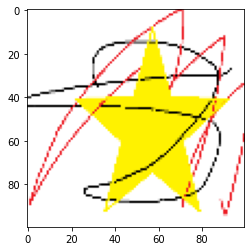

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

im = cv2.imread("test.png")
im2 = cv2.imread("../pictures/blue_green.png")
im_rgb=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#im_rgb = im

im_rgb = cv2.resize(im_rgb, (100, 100))
plt.imshow(im_rgb)


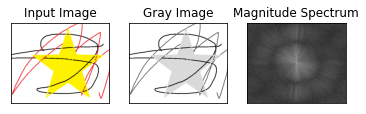

bgr:  [0.28034635 0.35248675 0.36716689]
base * freq * color = value
hp(green) info : 100.000000 * 3.186886 * 1.140927 = 364
atk(red) info: 100.000000 * 1.396204 * 1.237939 = 173
def(blue) info: 100.000000 * 0.603796 * 0.721709 = 44
status: 364 173 44



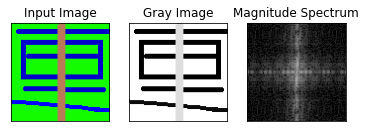

bgr:  [0.22900239 0.66830049 0.10269711]
base * freq * color = value
hp(green) info : 100.000000 * 2.205864 * 4.101245 = 905
atk(red) info: 100.000000 * 1.177108 * 0.096848 = 11
def(blue) info: 100.000000 * 0.822892 * 0.481562 = 40
status: 905 11 40



In [8]:
from math import log

#ステータスを生成して返す
def generateStatus(image, debug=False):
    #rgb成分の割合の算出
    bgr_hist = image.T.sum(axis=1).sum(axis=1) 
    bgr_hist = bgr_hist / max(sum(bgr_hist), 1)
    
    #グレースケール画像
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 256
    
    #フーリエ変換・パワースペクトル画像の算出
    f = np.fft.fft2(image_gray, axes=(0,1))
    fshift = np.fft.fftshift(f)
    foo = np.abs(fshift)
    foo = np.where(foo < 1, 1, foo)
    magnitude_spectrum = 20 * np.log(foo) 

    h, w = magnitude_spectrum.shape
    
    #振幅の和
    sum_spec = np.sum(magnitude_spectrum) / w / h
    sum_spec = sum_spec if sum_spec > 0 else 1
    
    #中心の1/4部分
    low = np.sum(magnitude_spectrum[h//4:h*3//4, w//4:w*3//4]) / w / h
    #それ以外　外周の部分
    high = sum_spec - low
    
    #それぞれの面積を考慮した値
    high_std = high * 4 / 3 / sum_spec # 面積の3/4を占めるので 4/3倍
    low_std = low * 4 / sum_spec # 面積の1/4を占めるので 4倍
    
    #単純な全体に占める割合
    high_ratio = high / sum_spec
    low_ratio = low / sum_spec
    
    #体力に関する定数値
    hp_base1 = 100
    hp_base2 = 1
    hp_freq = (log(sum_spec) -hp_base2)
    hp_color = (bgr_hist[1]/0.33)**2
    
    #攻撃力に関する定数値
    attack_base = 100
    attack_freq = high_ratio/0.5
    attack_color = (bgr_hist[2]/0.33)**2
    
    #防御力に関する定数値
    defence_base = 100
    defence_freq = low_ratio/0.5
    defence_color = (bgr_hist[0]/0.33)**2
        
    status = Status()
    status.hp = max(1, round(hp_base1 * hp_freq * hp_color))
    status.attack = max(1, round(attack_base * attack_freq * attack_color))
    status.defence = max(1, round(defence_base * defence_freq * defence_color))
    
    if debug:
        #テスト用の出力
        im_rgb=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.gray()
        plt.subplot(131),plt.imshow(im_rgb)
        plt.title('Input Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(image_gray)
        plt.title('Gray Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(np.round(magnitude_spectrum.astype(np.uint8)), cmap = 'gray')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
        plt.show()
        print("bgr: " , bgr_hist)
        #print("sum:", sum_spec, log(sum_spec))
        #print("high:", high, high_ratio, high_std)
        #print("low:", low, low_ratio, low_std)
        
        print("base * freq * color = value")
        print("hp(green) info : %f * %f * %f = %d" % (hp_base1, hp_freq, hp_color, status.hp))
        print("atk(red) info: %f * %f * %f = %d" % (attack_base, attack_freq, attack_color, status.attack))
        print("def(blue) info: %f * %f * %f = %d" % (defence_base, defence_freq, defence_color, status.defence))

        print("status:", status.hp, status.attack, status.defence)
        print("")
        
    return status


a = generateStatus(im, True)
b = generateStatus(im2, True)

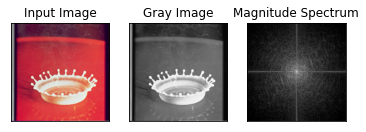

bgr:  [0.24453802 0.2159163  0.53954569]
base * freq * color = value
hp(green) info : 100.000000 * 2.292052 * 0.428098 = 98
atk(red) info: 100.000000 * 1.014968 * 2.673182 = 271
def(blue) info: 100.000000 * 0.985032 * 0.549117 = 54
status: 98 271 54



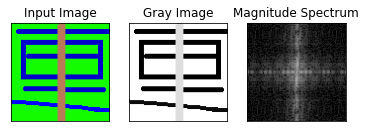

bgr:  [0.22900239 0.66830049 0.10269711]
base * freq * color = value
hp(green) info : 100.000000 * 2.205864 * 4.101245 = 905
atk(red) info: 100.000000 * 1.177108 * 0.096848 = 11
def(blue) info: 100.000000 * 0.822892 * 0.481562 = 40
status: 905 11 40



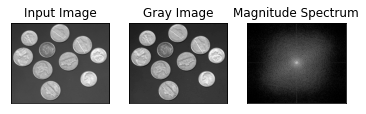

bgr:  [0.33333333 0.33333333 0.33333333]
base * freq * color = value
hp(green) info : 100.000000 * 2.289301 * 1.020304 = 234
atk(red) info: 100.000000 * 0.845685 * 1.020304 = 86
def(blue) info: 100.000000 * 1.154315 * 1.020304 = 118
status: 234 86 118



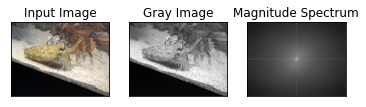

bgr:  [0.30227562 0.33535292 0.36237147]
base * freq * color = value
hp(green) info : 100.000000 * 3.100011 * 1.032705 = 320
atk(red) info: 100.000000 * 1.265289 * 1.205813 = 153
def(blue) info: 100.000000 * 0.734711 * 0.839032 = 62
status: 320 153 62



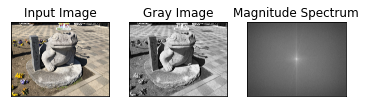

bgr:  [0.30531548 0.33704951 0.357635  ]
base * freq * color = value
hp(green) info : 100.000000 * 3.517673 * 1.043181 = 367
atk(red) info: 100.000000 * 1.398291 * 1.174498 = 164
def(blue) info: 100.000000 * 0.601709 * 0.855992 = 52
status: 367 164 52



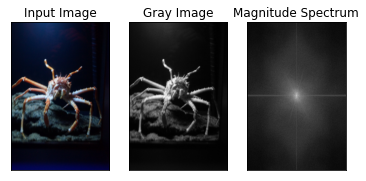

bgr:  [0.44741805 0.29357302 0.25900893]
base * freq * color = value
hp(green) info : 100.000000 * 2.607014 * 0.791415 = 206
atk(red) info: 100.000000 * 1.151261 * 0.616030 = 71
def(blue) info: 100.000000 * 0.848739 * 1.838227 = 156
status: 206 71 156



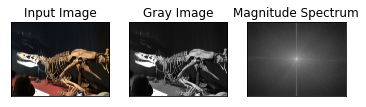

bgr:  [0.28510443 0.32190415 0.39299142]
base * freq * color = value
hp(green) info : 100.000000 * 3.107516 * 0.951536 = 296
atk(red) info: 100.000000 * 1.268765 * 1.418203 = 180
def(blue) info: 100.000000 * 0.731235 * 0.746414 = 55
status: 296 180 55



In [9]:
images = []
images.append(cv2.imread("../pictures/milkdrop.bmp"))
images.append(cv2.imread("../pictures/blue_green.png"))
images.append(cv2.imread("../pictures/coins.jpg"))
images.append(cv2.imread("../pictures/ika.jpg"))
images.append(cv2.imread("../pictures/kaeru.jpg"))
images.append(cv2.imread("../pictures/kani.jpg"))
images.append(cv2.imread("../pictures/kyoryu.jpg"))

for i in images:
    generateStatus(i, True)

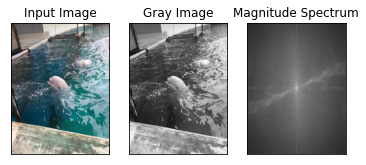

base * freq * color = value
hp(green) info : 100.000000 * 3.361538 * 1.128065 = 379
atk(red) info: 100.000000 * 1.344931 * 0.804386 = 108
def(blue) info: 100.000000 * 0.655069 * 1.147734 = 75
status: 379 108 75



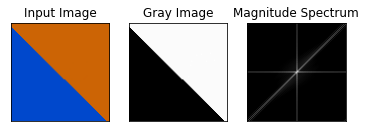

base * freq * color = value
hp(green) info : 100.000000 * 0.183505 * 0.807248 = 15
atk(red) info: 100.000000 * 0.737030 * 1.289900 = 95
def(blue) info: 100.000000 * 1.262970 * 0.992207 = 125
status: 15 95 125



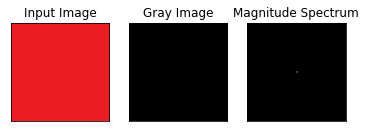

base * freq * color = value
hp(green) info : 100.000000 * -5.113402 * 0.079461 = 1
atk(red) info: 100.000000 * 0.000000 * 5.692930 = 1
def(blue) info: 100.000000 * 2.000000 * 0.131354 = 26
status: 1 1 26



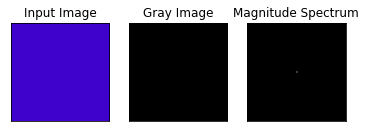

base * freq * color = value
hp(green) info : 100.000000 * -5.209572 * 0.000508 = 1
atk(red) info: 100.000000 * 0.000000 * 0.503673 = 1
def(blue) info: 100.000000 * 2.000000 * 5.281143 = 1056
status: 1 1 1056



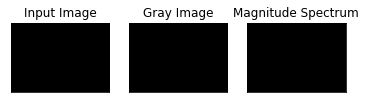

base * freq * color = value
hp(green) info : 100.000000 * -1.000000 * 0.000000 = 1
atk(red) info: 100.000000 * 2.000000 * 0.000000 = 1
def(blue) info: 100.000000 * 0.000000 * 0.000000 = 1
status: 1 1 1



In [58]:
images = []
images.append(cv2.imread("../pictures/test2.jpg"))
images.append(cv2.imread("../pictures/test3.png"))
images.append(cv2.imread("../pictures/red.png"))
images.append(cv2.imread("../pictures/blue.png"))
images.append(cv2.imread("../pictures/black.png"))

for i in images:
    generateStatus(i, True)

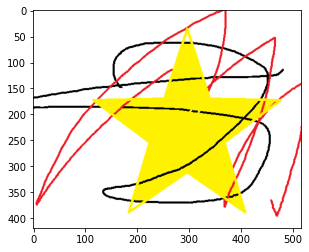

In [12]:
im = cv2.imread("test.png")
#im = cv2.imread("../pictures/black.png")
#im = cv2.imread("../pictures/test4.png")
tmp1 = im == 0
#mask = (tmp1[:,:,0] * tmp1[:,:,1] * tmp1[:,:,2]) == 0
mask = np.zeros((im.shape[0],im.shape[1])) == 0

def convertImage(image, mask=None):
    if mask is None:
        return image

    bgrAverage = image[mask == 1].T

    colorAverage = np.average(image[mask], axis=0)
    image[mask == 0] = colorAverage
    
    return image
    
image = convertImage(im, mask)
im_rgb=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)

In [25]:
import subprocess
from subprocess import PIPE

subprocess.run('ls')

FileNotFoundError: [WinError 2] 指定されたファイルが見つかりません。